In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import random
from astropy.io import fits
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.table import Table, hstack

### Import the relevant files

In [18]:
hsc_cosmos_path= '/global/cscratch1/sd/damonge/HSC/HSC_processed/DEEP_COSMOS/DEEP_COSMOS_Catalog_i24.50.fits'
hdulist = fits.open(hsc_cosmos_path)
hsc_cosmos_data = hdulist[1].data
hsc_cosmos_columns= hdulist[1].columns

cosmos_path= '/global/cscratch1/sd/damonge/HSC/COSMOS2015_Laigle+_v1.1.fits'
hdulist = fits.open(cosmos_path)
cosmos_data = hdulist[1].data
cosmos_columns= hdulist[1].columns

In [33]:
len(hsc_cosmos_data) #537547 now 527452
len(cosmos_data) #1182108
hsc_cosmos_data.columns

ColDefs(
    name = 'object_id'; format = 'K'
    name = 'ra'; format = 'D'
    name = 'dec'; format = 'D'
    name = 'tract'; format = 'J'
    name = 'patch'; format = 'J'
    name = 'merge_peak_g'; format = 'L'
    name = 'merge_peak_r'; format = 'L'
    name = 'merge_peak_i'; format = 'L'
    name = 'merge_peak_z'; format = 'L'
    name = 'merge_peak_y'; format = 'L'
    name = 'gcountinputs'; format = 'I'
    name = 'rcountinputs'; format = 'I'
    name = 'icountinputs'; format = 'I'
    name = 'zcountinputs'; format = 'I'
    name = 'ycountinputs'; format = 'I'
    name = 'iflags_pixel_bright_object_center'; format = 'L'
    name = 'iflags_pixel_bright_object_any'; format = 'L'
    name = 'iclassification_extendedness'; format = 'E'
    name = 'iblendedness_abs_flux'; format = 'E'
    name = 'a_g'; format = 'E'
    name = 'a_r'; format = 'E'
    name = 'a_i'; format = 'E'
    name = 'a_z'; format = 'E'
    name = 'a_y'; format = 'E'
    name = 'gflux_psf'; format = 'D'
    name = 

### Cut COSMOS 30-band so they match HSC

See https://arxiv.org/pdf/1704.05988.pdf 3rd page on "COSMOS data" part 2, "Photo-z"

In [21]:
lim_indices = np.where((0.01 < cosmos_data['PHOTOZ']) & (9 > cosmos_data['PHOTOZ']) & (cosmos_data['TYPE'] == 0) & (cosmos_data['ZP_2'] < 0) & (cosmos_data['MASS_BEST'] > 7.5) 
            & (np.maximum(cosmos_data['ZPDF_H68'] - cosmos_data['ZPDF'], cosmos_data['ZPDF'] - cosmos_data['ZPDF_L68']) < 0.05*(1+cosmos_data['PHOTOZ']))
            & (cosmos_data['CHI2_BEST'] < cosmos_data['CHIS']) & (cosmos_data['CHI2_BEST']/cosmos_data['NBFILT'] < 5.))

cosmos_data_cut= cosmos_data[lim_indices] #length= 197640


/global/common/cori/software/python/3.6-anaconda-5.2/lib/python3.6/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()


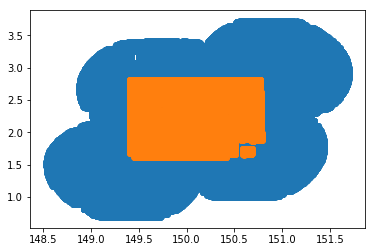

In [22]:
#blue- HSC, orange- COSMOS
plt.scatter(hsc_cosmos_data['ra'], hsc_cosmos_data['dec'])
plt.scatter(cosmos_data_cut['ALPHA_J2000'], cosmos_data_cut['DELTA_J2000'])


### Match the 30-band COSMOS to the HSC

In [23]:
cosmos_skycoord = SkyCoord(ra = cosmos_data_cut['ALPHA_J2000'] * u.deg, dec = cosmos_data_cut['DELTA_J2000']*u.deg)

hsc_skycoord = SkyCoord(ra = hsc_cosmos_data['ra'] * u.deg, dec = hsc_cosmos_data['dec'] * u.deg)
    
#hsc_index, dist_2d, dist_3d = cosmos_skycoord.match_to_catalog_sky(hsc_skycoord) This was for every cosmos, find a matching HSC

#Instead, I should do for every hsc, find matching COSMOS, as the hsc sample is much smaller and shallower
cosmos_index, dist_2d, dist_3d = hsc_skycoord.match_to_catalog_sky(cosmos_skycoord)

In [24]:
#cosmos_index is the indicies of cosmos_data_cut that match each of the hsc objects. Has same length as hsc_cosmos_data
#mask is a boolean array based on the distances of the resulting cosmos matches (True if dist<1arcsec)
mask=dist_2d.degree*60*60<1 #
cosmos_good=cosmos_data_cut[cosmos_index[mask]] #len= 90511 then 89867
hsc_good=hsc_cosmos_data[mask] #len= 90511 then 89867

In [26]:
len(cosmos_good)

89867

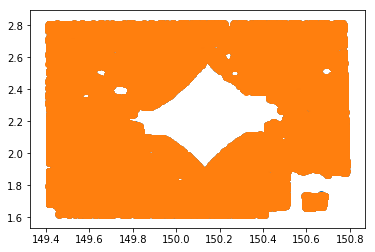

In [27]:
plt.scatter(cosmos_good['ALPHA_J2000'], cosmos_good['DELTA_J2000'])
plt.scatter(hsc_good['ra'], hsc_good['dec'])


(array([ 40873.,  37470.,   7312.,   1887.,    880.,    497.,    314.,
           240.,    212.,    182.]),
 array([  6.50568491e-04,   1.00578187e-01,   2.00505805e-01,
          3.00433423e-01,   4.00361042e-01,   5.00288660e-01,
          6.00216278e-01,   7.00143897e-01,   8.00071515e-01,
          8.99999133e-01,   9.99926752e-01]),
 <a list of 10 Patch objects>)

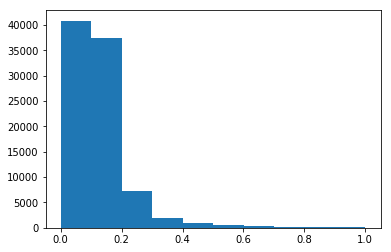

In [28]:
plt.hist(dist_2d[mask].degree*60*60)

### Make a fits file with this match

In [34]:
cosmos_good_df= pd.DataFrame(cosmos_good)
hsc_good_mag_df= pd.DataFrame(np.transpose([hsc_good['gcmodel_mag'], hsc_good['rcmodel_mag'], hsc_good['icmodel_mag'], hsc_good['zcmodel_mag'], hsc_good['ycmodel_mag'], hsc_good['pz_mean_eab'], hsc_good['pz_mode_eab'], hsc_good['pz_best_eab'], hsc_good['pz_mc_eab'], hsc_good['pz_mean_frz'],hsc_good['pz_mode_frz'],hsc_good['pz_best_frz'],hsc_good['pz_mc_frz'], hsc_good['pz_mean_nnz'], hsc_good['pz_mode_nnz'], hsc_good['pz_best_nnz'], hsc_good['pz_mc_nnz']]),index=range(89867),columns=['gcmodel_mag','rcmodel_mag','icmodel_mag','zcmodel_mag','ycmodel_mag', 'pz_mean_eab', 'pz_mode_eab', 'pz_best_eab', 'pz_mc_eab', 'pz_mean_frz','pz_mode_frz','pz_best_frz','pz_mc_frz','pz_mean_nnz','pz_mode_nnz','pz_best_nnz','pz_mc_nnz'])

t1 = Table.from_pandas(cosmos_good_df)
t2 = Table.from_pandas(hsc_good_mag_df)

In [35]:
matched_catalog= hstack([t1, t2])
matched_catalog.write('../../../cosmos_matched_SNcut_hsc_1arcsec_deblend_cuts.fits')

In [36]:
cosmos_matched_path= '../../../cosmos_matched_SNcut_hsc_1arcsec_deblend_cuts.fits'
hdulist = fits.open(cosmos_matched_path)
cosmos_matched_data = hdulist[1].data
cosmos_matched_df= pd.DataFrame(cosmos_matched_data)

In [38]:
cosmos_matched_df.head()

,ALPHA_J2000,DELTA_J2000,NUMBER,X_IMAGE,Y_IMAGE,ERRX2_IMAGE,ERRY2_IMAGE,ERRXY_IMAGE,FLAG_HJMCC,FLUX_RADIUS,...,pz_best_eab,pz_mc_eab,pz_mean_frz,pz_mode_frz,pz_best_frz,pz_mc_frz,pz_mean_nnz,pz_mode_nnz,pz_best_nnz,pz_mc_nnz
0,149.453697,1.619731,223167,38613.652344,7893.300293,0.001162,0.001010,0.000099,0,3.545569,...,0.532564,0.327275,0.723626,0.57,0.59,0.567385,0.667652,0.705,0.705,0.707358
1,149.459778,1.619942,223356,38467.738281,7898.336914,0.001521,0.001726,0.000072,0,4.009595,...,0.579725,0.709972,0.719739,0.62,0.60,0.784233,0.749815,0.635,0.625,0.632712
2,149.482316,1.625156,226624,37926.894531,8023.321289,0.000584,0.000667,0.000108,0,4.142091,...,0.575558,0.581394,0.602711,0.63,0.61,0.508874,0.398997,0.215,0.335,0.099019
3,149.496974,1.625868,227066,37575.187500,8040.296875,0.000294,0.000271,0.000024,0,4.170648,...,2.277613,0.302322,1.814427,1.89,1.92,2.071863,1.688815,2.675,2.345,0.153308
4,149.475738,1.626337,227113,38084.710938,8051.709961,0.000907,0.000769,0.000048,0,3.648163,...,1.290852,1.241290,1.317414,1.29,1.31,1.339371,1.274344,1.275,1.275,1.174628
